In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import norm, probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch import arch_model

###### Part 0: Data Preparation

In [2]:
# ------------------------------
# Load and Transform Data
# ------------------------------
# Load data
df_original = pd.read_csv('final_data.csv', index_col=0)
df = df_original.drop(['Portfolio_Value', 'CPI', 'T10Y2Y', 'RF'], axis=1)

# Convert tuple column names to single string format
def parse_and_combine_column_names(columns):
    new_columns = []
    for col in columns:
        if col.startswith('(') and col.endswith(')'):  # Check if column name looks like a tuple
            try:
                # Parse the string into a tuple
                col_tuple = literal_eval(col)
                if isinstance(col_tuple, tuple):  # Ensure it's a tuple
                    new_col = f"{col_tuple[0]}_{col_tuple[1]}" if pd.notna(col_tuple[1]) else col_tuple[0]
                else:
                    new_col = col  # Keep the original name if not a tuple
            except (ValueError, SyntaxError):
                new_col = col  # Keep the original name if parsing fails
        else:
            new_col = col  # Keep the original name if not a tuple
        new_columns.append(new_col)
    return new_columns

# Apply the function to transform column names
df.columns = parse_and_combine_column_names(df.columns)


In [3]:
# ------------------------------
# Check and Handle Stationarity
# ------------------------------
# Augmented Dickey-Fuller test for stationarity
def adf_test(series, max_diff=2):
    """Augmented Dickey-Fuller test with automatic differencing"""
    original_series = series.copy()
    results = {}
    for i in range(max_diff + 1):
        result = adfuller(original_series.dropna())
        p_value = result[1]
        is_stationary = p_value < 0.05
        
        results[f'Diff_{i}'] = {
            'ADF Statistic': result[0],
            'p-value': p_value,
            'Critical Values': result[4],
            'is_stationary': is_stationary
        }
        
        if is_stationary:
            break
        
        original_series = original_series.diff().dropna()  # Differencing if not stationary

    final_result = results[f'Diff_{min(i, max_diff)}']
    final_result['diff_order'] = min(i, max_diff)
    return original_series, pd.Series(final_result)

# Apply ADF test to each column
transformed_columns = {}
stationarity_results = {}

for col in df.columns:
    transformed_series, adf_result = adf_test(df[col])
    transformed_columns[col] = transformed_series
    stationarity_results[col] = adf_result

# Create transformed DataFrame
stationary_df = pd.DataFrame(transformed_columns)
stationary_df.dropna(inplace=True)

adf_results_df = pd.DataFrame(stationarity_results).T
adf_results_df

,ADF Statistic,p-value,Critical Values,is_stationary,diff_order
Portfolio_Return,-7.334489,0.0,"{'1%': -3.526004646825607, '5%': -2.9032002348...",True,0
Inflation,-6.160173,0.0,"{'1%': -3.5335601309235605, '5%': -2.906443688...",True,1
GDP_Growth,-3.405061,0.010788,"{'1%': -3.5352168748293127, '5%': -2.907154082...",True,0
Yield_Change,-6.060141,0.0,"{'1%': -3.524624466842421, '5%': -2.9026070739...",True,0
Mkt-RF,-7.159108,0.0,"{'1%': -3.526004646825607, '5%': -2.9032002348...",True,0
SMB,-6.051009,0.0,"{'1%': -3.524624466842421, '5%': -2.9026070739...",True,0
HML,-7.187835,0.0,"{'1%': -3.524624466842421, '5%': -2.9026070739...",True,0
Technology_RSI,-8.522772,0.0,"{'1%': -3.524624466842421, '5%': -2.9026070739...",True,0
Technology_30dVol,-4.575407,0.000143,"{'1%': -3.524624466842421, '5%': -2.9026070739...",True,0
Healthcare_RSI,-7.504617,0.0,"{'1%': -3.526004646825607, '5%': -2.9032002348...",True,0


In [4]:
# ------------------------------
# Split Data
# ------------------------------
# Split for modeling and backtesting
model_df = stationary_df[:'2023-01-01']
backtest_df = stationary_df['2023-01-01':]

# Time-based split for training and testing
split_date = model_df.index[int(len(model_df) * 0.8)]
X_train = model_df.loc[:split_date].drop(columns=['Portfolio_Return'])
y_train = model_df.loc[:split_date, 'Portfolio_Return']
X_test = model_df.loc[split_date:].drop(columns=['Portfolio_Return'])
y_test = model_df.loc[split_date:, 'Portfolio_Return']

##### Part 1: Modeling

In [5]:
# ---------------------------------------
# Model 1: Backward Stepwise Regression
# ---------------------------------------
def backward_stepwise_regression(X, y, significance_level=0.05):
    X = sm.add_constant(X)  # Add intercept term
    remaining_features = list(X.columns)
    
    while len(remaining_features) > 1:
        model = sm.OLS(y, X[remaining_features]).fit()
        p_values = model.pvalues.drop('const')  # Ignore intercept
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            worst_feature = p_values.idxmax()
            remaining_features.remove(worst_feature)
        else:
            break  # Stop if all p-values are below threshold
    
    final_model = sm.OLS(y, X[remaining_features]).fit()
    return final_model, remaining_features

# Run Stepwise Regression
regression_model, selected_features = backward_stepwise_regression(X_train, y_train)

In [6]:
# ------------------------------------------------------
# Model 1: Variance Inflation Factor (VIF) Elimination
# ------------------------------------------------------
def calculate_vif(X):
    """Calculate Variance Inflation Factor (VIF) for each feature."""
    vif_data = pd.DataFrame({
        "Factor": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vif_data

def remove_high_vif(X, threshold=5):
    vif_data = calculate_vif(X)
    print("\nInitial VIF Scores:")
    print(vif_data)

    # Only perform elimination if any VIF exceeds the threshold
    if vif_data['VIF'].max() <= threshold:
        print("\nNo VIF values exceed the threshold. No features removed.")
        return X

    # Iteratively remove features with highest VIF
    features = X.copy()
    removed = []
    while True:
        vif_data = calculate_vif(features)
        max_vif = vif_data['VIF'].max()

        if max_vif <= threshold:
            break  # Stop if all remaining VIF values are acceptable

        max_idx = vif_data['VIF'].idxmax()
        removed_feature = vif_data.loc[max_idx, 'Factor']
        removed.append(removed_feature)

        print(f"Removing '{removed_feature}' (VIF = {max_vif:.2f})")
        features = features.drop(columns=removed_feature)
        
    print(f"\nFinal VIF Scores:")
    print(calculate_vif(features))
    
    return features

# Apply VIF elimination
X_train_selected = remove_high_vif(X_train[selected_features[1:]])
final_factors = X_train_selected.columns


Initial VIF Scores:
                   Factor        VIF
0              GDP_Growth   2.573935
1                  Mkt-RF   1.254650
2                     HML   1.326921
3   Consumer Cyclical_RSI  10.607160
4     Basic Materials_RSI  10.703080
5  Basic Materials_30dVol  31.790310
6      Real Estate_30dVol  26.968066
Removing 'Basic Materials_30dVol' (VIF = 31.79)
Removing 'Basic Materials_RSI' (VIF = 10.64)
Removing 'Consumer Cyclical_RSI' (VIF = 5.23)

Final VIF Scores:
               Factor       VIF
0          GDP_Growth  1.207715
1              Mkt-RF  1.023428
2                 HML  1.195177
3  Real Estate_30dVol  1.185569


                            OLS Regression Results                            
Dep. Variable:       Portfolio_Return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     141.2
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.69e-24
Time:                        10:08:23   Log-Likelihood:                -77.325
No. Observations:                  49   AIC:                             164.7
Df Residuals:                      44   BIC:                             174.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.9121      0

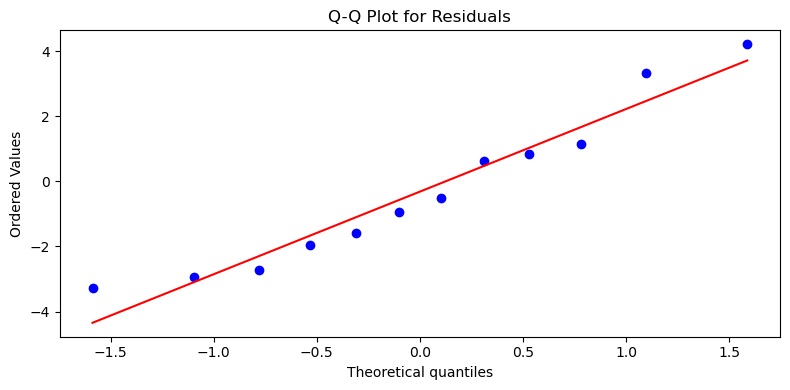

In [7]:
# ------------------------------
# Model 1: Model Evaluation
# ------------------------------
regression_refined_model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()
print(regression_refined_model.summary())

# Predictions and residuals
y_pred_reg = regression_refined_model.predict(sm.add_constant(X_test[final_factors]))
residuals_reg = y_test - y_pred_reg

# Evaluation metrics
print("\nModel Evaluation:".center(80))
print("="*40)
print(f"R²: {r2_score(y_test, y_pred_reg):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_reg):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_reg):.4f}")

# Residual analysis
plt.figure(figsize=(8, 4))
probplot(residuals_reg, dist="norm", plot=plt)
plt.title('Q-Q Plot for Residuals')
plt.tight_layout()
plt.show()

Note: 
1. All independent variables have p-values < 0.05, indicating statistical significance.
2. The probability of the F-statistic is < 0.05, confirming overall model significance.
3. The adjusted R-squared for the training data exceeds 70%, indicating that the model explains a substantial portion of the variance while accounting for the number of predictors.
4. The Durbin-Watson statistic is greater than 2, suggesting no strong autocorrelation.
5. The R-squared for the testing data exceeds 70%, signifying strong explanatory power on unseen data.
6. The Q-Q plot shows data points closely following the reference line, indicating normality in residual distribution.

In [8]:
# ------------------------------ 
# Model 2: PCA Modeling
# ------------------------------
def perform_pca(X, variance_threshold=0.90):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit PCA with all components
    pca = PCA()
    pca.fit(X_scaled)
    
    # Determine optimal number of components
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    if n_components == 0:
        n_components = 1
        print(f"Warning: Variance threshold {variance_threshold} not reached. Using first component.")
    
    X_pca = pca.transform(X_scaled)[:, :n_components]
    explained_variance = pca.explained_variance_ratio_[:n_components]
    
    return scaler, pca, X_pca, explained_variance, n_components

# Perform PCA on training data
scaler, pca, X_train_pca, explained_variance, n_components = perform_pca(X_train)

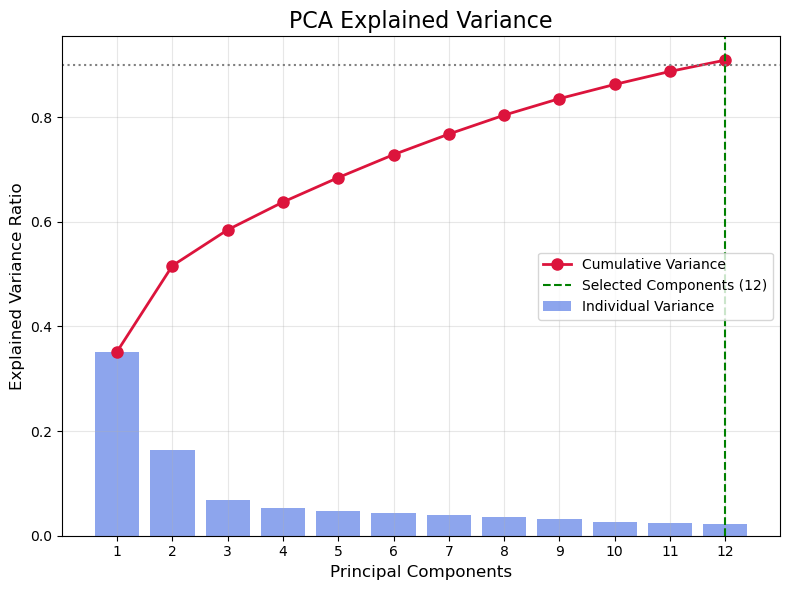

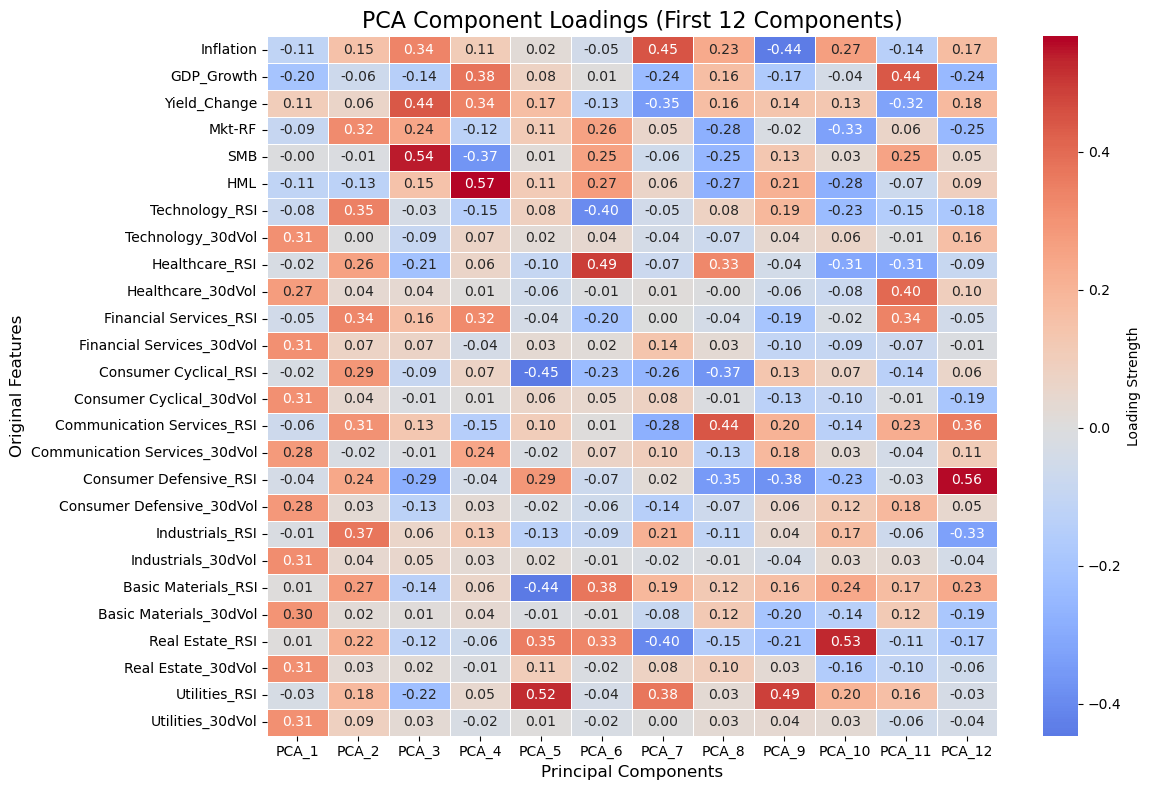

In [9]:
# ------------------------------
# Model 2: PCA Visualization
# ------------------------------
# PCA Visualization
plt.figure(figsize=(8, 6))
components = range(1, n_components + 1)
bars = plt.bar(components, explained_variance, alpha=0.6, color='royalblue', label='Individual Variance')
cumulative = np.cumsum(explained_variance)
line = plt.plot(components, cumulative, 'o-', color='crimson', linewidth=2, markersize=8, label='Cumulative Variance')

plt.axvline(n_components, color='green', linestyle='--', label=f'Selected Components ({n_components})')
plt.axhline(0.9, color='gray', linestyle=':')

plt.title('PCA Explained Variance', fontsize=16)
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xticks(components)
plt.legend(loc='center right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PCA Loadings Heatmap
loadings = pd.DataFrame(pca.components_[:n_components].T, columns=[f'PCA_{i+1}' for i in range(n_components)], index=X_train.columns)
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True, fmt=".2f", cbar_kws={'label': 'Loading Strength'}, linewidths=0.5)
plt.title(f'PCA Component Loadings (First {n_components} Components)', fontsize=16)
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Original Features', fontsize=12)
plt.tight_layout()
plt.show()


Interpret PCA components:

PCA_1: Market Volatility, PCA_2: Market Return, PCA_3: Size, PCA_4: Value, PCA_5: Defensive Sectors Return,

PCA_6: Healthcare Sector Return, PCA_7: Inflation, PCA_8: Communication Services Sector Return,

PCA_9: Utilities Sector Return, PCA_10: Real Estate Sector Return, PCA_11: GDP Growth, PCA_12: Consumer Defensive Sector Return

In [10]:
# -----------------------------------------------------------
# Model 2: PCA Regression Modeling with Stepwise Refinement
# -----------------------------------------------------------
def stepwise_refinement(X_train_pca_df, y_train, pca_model, significance_level=0.05):
    """
    Perform stepwise refinement by removing the least significant PCA component one by one.
    """
    refined_model = pca_model
    X_refined = X_train_pca_df.copy()  # Initial dataframe with all components
    significant_components = X_refined.columns  # All components initially
    
    while True:
        # Fit the model with current components
        X_refined_const = sm.add_constant(X_refined)
        model = sm.OLS(y_train, X_refined_const).fit()
        
        # Get p-values and check for the least significant component
        p_values = model.pvalues[1:]  # Exclude constant
        max_p_value = p_values.max()  # Find the largest p-value (the least significant)
        
        if max_p_value > significance_level:
            # Remove the least significant component
            component_to_remove = p_values.idxmax()
            X_refined = X_refined.drop(columns=[component_to_remove])
            print(f"Removing component: {component_to_remove} with p-value: {max_p_value:.4f}")
        else:
            # If all components are significant, break out of the loop
            break
    
    # Final refined model
    refined_model = sm.OLS(y_train, sm.add_constant(X_refined)).fit()
    print("\nRefined PCA Model Summary:".center(80))
    print(refined_model.summary())
    
    return refined_model, X_refined

# Create PCA component names
pca_component_names = [f'PCA_{i+1}' for i in range(n_components)]

# Initial OLS model with all PCA components
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_component_names, index=X_train.index)
X_train_pca_const = sm.add_constant(X_train_pca_df)
pca_model = sm.OLS(y_train, X_train_pca_const).fit()

print("Initial PCA Model Summary:".center(80))
print(pca_model.summary())

# Perform stepwise refinement
pca_refined_model, X_train_pca_refined = stepwise_refinement(X_train_pca_df, y_train, pca_model)
significant_components = pca_refined_model.params[1:].index  # Exclude intercept

                           Initial PCA Model Summary:                           
                            OLS Regression Results                            
Dep. Variable:       Portfolio_Return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     22.90
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           2.65e-13
Time:                        10:08:24   Log-Likelihood:                -88.883
No. Observations:                  49   AIC:                             203.8
Df Residuals:                      36   BIC:                             228.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

Note: 
1. All independent variables have p-values < 0.05, indicating statistical significance.
2. The probability of the F-statistic is < 0.05, confirming overall model significance.
3. The adjusted R-squared for the training data exceeds 70%.
4. The Durbin-Watson statistic is greater than 2, suggesting no strong autocorrelation.

In [11]:
# ------------------------------
# Model 2: Model Evaluation
# ------------------------------
# Test data transformation
X_test_scaled = scaler.transform(X_test)
X_test_pca_df = pd.DataFrame(pca.transform(X_test_scaled)[:, :n_components], 
                             columns=pca_component_names, 
                             index=X_test.index)

if not significant_components.empty:
    X_test_pca_refined = sm.add_constant(X_test_pca_df[significant_components])
else:
    X_test_pca_refined = sm.add_constant(X_test_pca_df)

# Generate predictions and calculate metrics
y_pred_pca = pca_refined_model.predict(X_test_pca_refined)
residuals_pca = y_test - y_pred_pca

print("\nModel Evaluation:".center(80))
print(f"R²: {r2_score(y_test, y_pred_pca):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_pca):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_pca):.4f}")

                               
Model Evaluation:                               
R²: 0.8645
MSE: 5.1110
MAE: 1.9543


Note:
Compared to Model 1, Model 2 has a higher R-squared and a lower Mean Squared Error, indicating that Model 2 provides a better fit to the data and makes more accurate predictions.

##### Part 2: Backtesting


VaR Violation Ratios:
Regression Model VaR:     0.16667
PCA Model VaR:            0.00000
Historical VaR:           0.08333


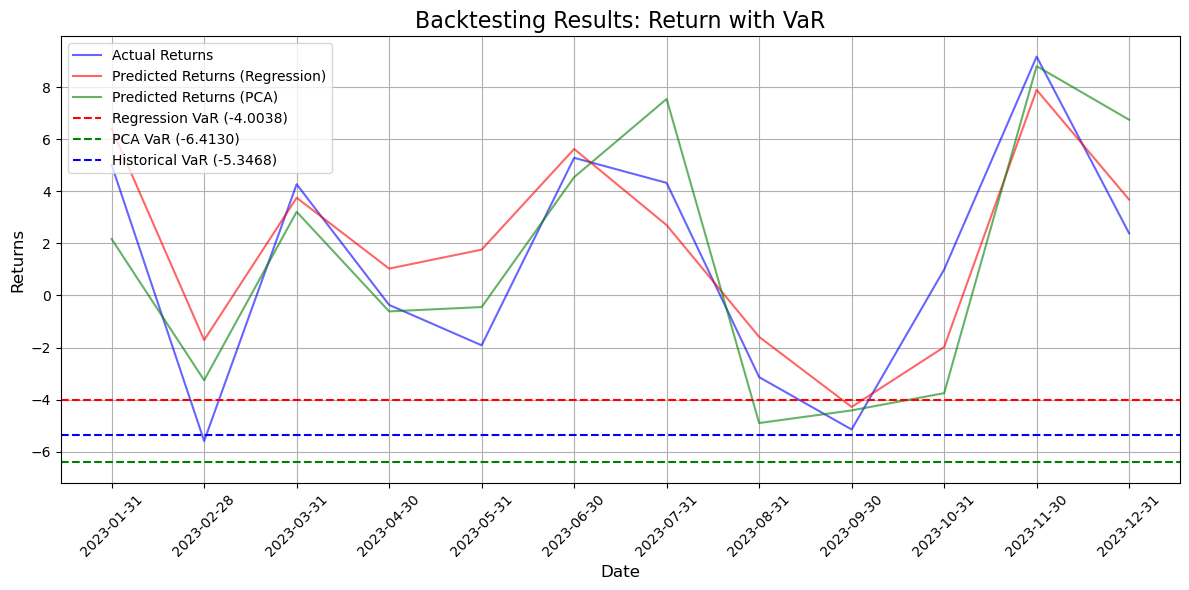

In [12]:
# ------------------
# VaR Calculations
# ------------------
def calculate_var(returns, confidence_level=0.95):
    """Calculate Parametric VaR using normal distribution."""
    mu = np.mean(returns)
    sigma = np.std(returns)
    var_parametric = norm.ppf(1 - confidence_level, mu, sigma)
    return var_parametric

# Data Transformation for Backtesting
X_backtest = backtest_df.drop(columns=['Portfolio_Return'])
y_backtest = backtest_df['Portfolio_Return']

# Parametric VaR for Regression model
X_backtest_filtered = X_backtest[final_factors]  # Filter based on final factors
y_backtest_pred_reg = regression_refined_model.predict(sm.add_constant(X_backtest_filtered))
regression_var = calculate_var(y_backtest_pred_reg)

# Parametric VaR for PCA model
X_backtest_scaled = scaler.transform(X_backtest)
X_backtest_pca_df = pd.DataFrame(pca.transform(X_backtest_scaled)[:, :n_components], 
                             columns=pca_component_names, 
                             index=X_backtest.index)
if not significant_components.empty:
    X_backtest_pca_refined = sm.add_constant(X_backtest_pca_df[significant_components])
else:
    X_backtest_pca_refined = sm.add_constant(X_backtest_pca_df) 

y_backtest_pred_pca = pca_refined_model.predict(X_backtest_pca_refined)
pca_var = calculate_var(y_backtest_pred_pca)

# Non-Parametric VaR
def historical_var(returns, alpha=0.05):
    """Calculate Historical VaR."""
    return np.percentile(returns, alpha * 100)

historical_var_value = historical_var(y_backtest)

# Violation Ratio
def violation_ratio(returns, var):
    """Calculate the violation ratio for VaR."""
    return np.mean(returns < var)

regression_violation_ratio = violation_ratio(y_backtest, regression_var)
pca_violation_ratio = violation_ratio(y_backtest, pca_var)
historical_violation_ratio = violation_ratio(y_backtest, historical_var_value)

print("\nVaR Violation Ratios:")
print(f"{'Regression Model VaR:':<25} {regression_violation_ratio:.5f}")
print(f"{'PCA Model VaR:':<25} {pca_violation_ratio:.5f}")
print(f"{'Historical VaR:':<25} {historical_violation_ratio:.5f}")

# Backtest Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_backtest.index, y_backtest, label='Actual Returns', color='blue', alpha=0.6)
plt.plot(y_backtest.index, y_backtest_pred_reg, label='Predicted Returns (Regression)', color='red', alpha=0.6)
plt.plot(y_backtest.index, y_backtest_pred_pca, label='Predicted Returns (PCA)', color='green', alpha=0.6)

# Plot the VaR lines
plt.axhline(y=regression_var, color='r', linestyle='--', label=f'Regression VaR ({regression_var:.4f})')
plt.axhline(y=pca_var, color='g', linestyle='--', label=f'PCA VaR ({pca_var:.4f})')
plt.axhline(y=historical_var_value, color='b', linestyle='--', label=f'Historical VaR ({historical_var_value:.4f})')

plt.title('Backtesting Results: Return with VaR', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Part 3: Risk Decomposition

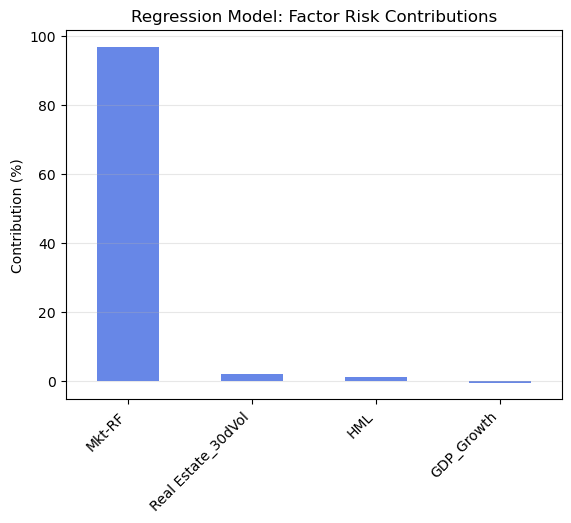

In [13]:
# ---------------------------------
# Using Factor in Regression Model
# ---------------------------------
# Regression model contributions
cov_matrix = X_backtest[final_factors].cov()
coefficients = regression_refined_model.params[1:]  # Exclude intercept
mc = coefficients.values * (cov_matrix @ coefficients.values)
total_risk = mc.sum()
reg_contributions = pd.Series(mc / total_risk * 100, index=final_factors)
reg_contributions = reg_contributions.sort_values(ascending=False)

# Visualize 
reg_contributions.plot(kind='bar', color='royalblue', alpha=0.8)
plt.title('Regression Model: Factor Risk Contributions')
plt.ylabel('Contribution (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

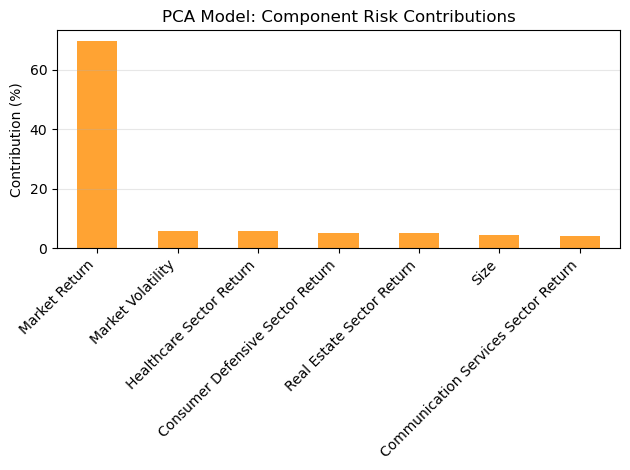

In [14]:
# ------------------------------
# Using Factor in PCA Model
# ------------------------------
# Dictionary for PCA component interpretation
pca_interpretation = {
    'PCA_1': 'Market Volatility',
    'PCA_2': 'Market Return',
    'PCA_3': 'Size',
    'PCA_4': 'Value',
    'PCA_5': 'Defensive Sectors Return',
    'PCA_6': 'Healthcare Sector Return',
    'PCA_7': 'Inflation',
    'PCA_8': 'Communication Services Sector Return',
    'PCA_9': 'Utilities Sector Return',
    'PCA_10': 'Real Estate Sector Return',
    'PCA_11': 'GDP Growth',
    'PCA_12': 'Consumer Defensive Sector Return'
}

# PCA model contributions
coefficients = pca_refined_model.params[1:]  # Exclude intercept
pca_components = coefficients.index  

variance_dict = dict(zip([f'PCA_{i+1}' for i in range(len(pca.explained_variance_))], 
                         pca.explained_variance_))
variances = np.array([variance_dict[comp] for comp in pca_components])

mc = (coefficients ** 2) * variances
total_risk = mc.sum()
pca_contributions = pd.Series(mc / total_risk * 100, index=pca_components)

pca_contributions.index = pca_contributions.index.map(pca_interpretation)
pca_contributions = pca_contributions.sort_values(ascending=False)

# Visualize Contributions
pca_contributions.plot(kind='bar', color='darkorange', alpha=0.8)
plt.title('PCA Model: Component Risk Contributions')
plt.ylabel('Contribution (%)')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


##### Part 4: Factor Correlation

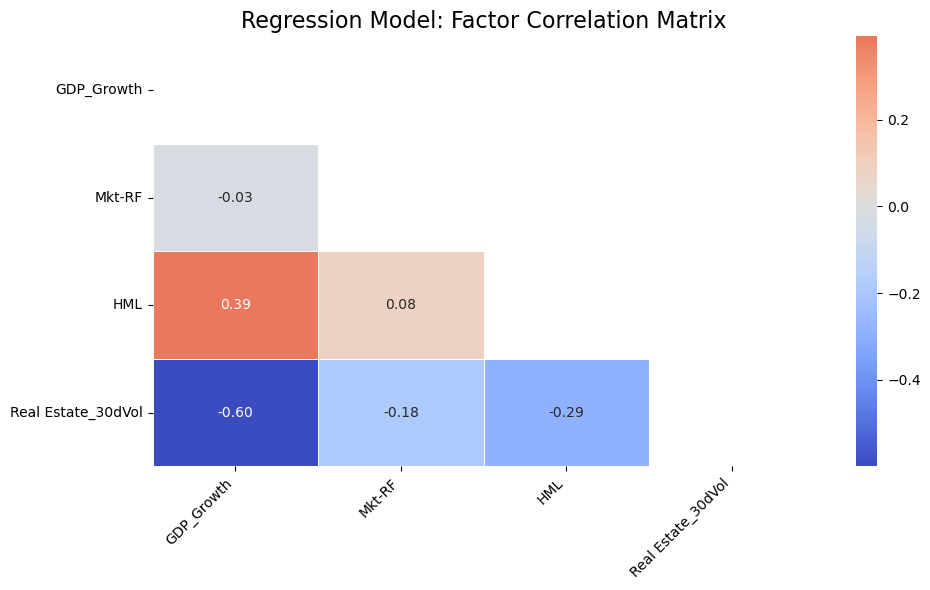

In [15]:
# ------------------------------
# Regression model
# ------------------------------
# Calculate correlation matrix
corr_matrix_regression = X_train[final_factors].corr()
mask_regression = np.triu(np.ones_like(corr_matrix_regression, dtype=bool))

# Visualize correlation
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_regression, mask=mask_regression, cmap='coolwarm', center=0,
            annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title('Regression Model: Factor Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right',)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

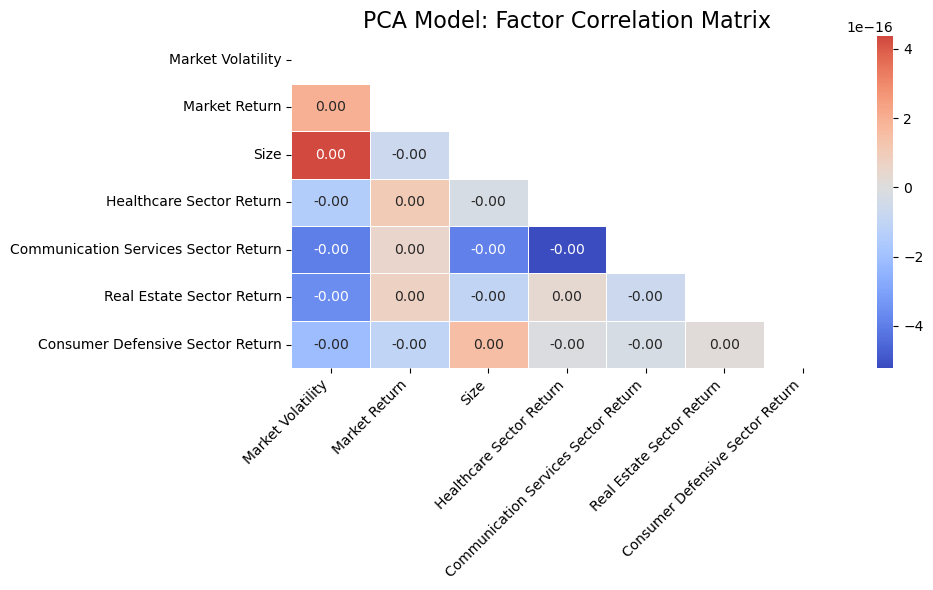

In [16]:
# ------------------------------
# PCA model - among components
# ------------------------------
# Apply the PCA interpretation to the column names
pca_labels = [pca_interpretation.get(col, 'Unknown') for col in X_train_pca_refined.columns]
X_train_pca_refined.columns = pca_labels

corr_matrix_pca = X_train_pca_refined.corr()

# Visualize correlation
plt.figure(figsize=(10, 6))
mask_pca = np.triu(np.ones_like(corr_matrix_pca, dtype=bool))
sns.heatmap(corr_matrix_pca, mask=mask_pca, cmap='coolwarm', center=0,
            annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title('PCA Model: Factor Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

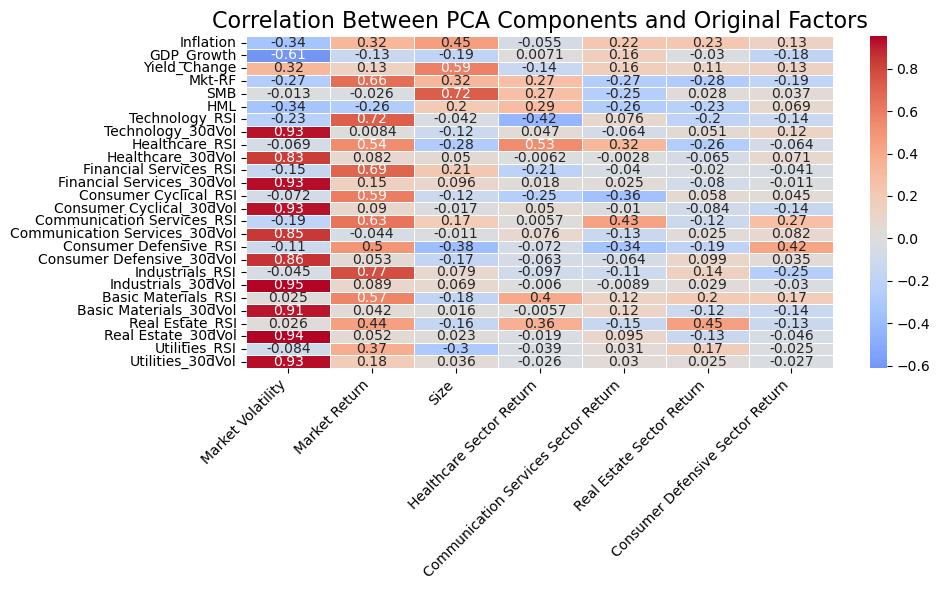

In [17]:
# ----------------------------------------------------
# PCA model - among components and original factors
# ----------------------------------------------------

# Calculate the correlation between each PCA component and all original factors
correlation_matrix = X_train_pca_refined.apply(lambda pca_component: X_train.corrwith(pca_component))

# Visualize correlation 
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Between PCA Components and Original Factors', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### Part 5: Stress Testing

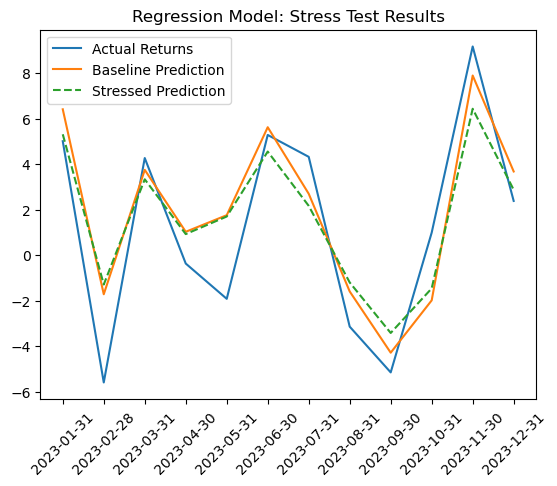


Mean Returns:
Mean Actual Returns: 1.2726
Mean Baseline Prediction: 1.9391
Mean Stressed Prediction: 1.6624


In [18]:
# Stress test scenario setup
X_stressed = X_backtest.copy()
X_stressed['Mkt-RF'] *= 0.8  # Simulate 30% decrease in market return
rsi_columns = [col for col in X_stressed.columns if 'rsi' in col.lower()]
X_stressed[rsi_columns] *= 0.8

# ------------------------
# Using Regression Model
# ------------------------
# Predict using the stressed input
y_stressed_pred_reg = regression_refined_model.predict(sm.add_constant(X_stressed[final_factors]))

# Plot results
plt.plot(y_backtest, label='Actual Returns')
plt.plot(y_backtest_pred_reg, label='Baseline Prediction')
plt.plot(y_stressed_pred_reg, label='Stressed Prediction', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.title('Regression Model: Stress Test Results')
plt.show()

result_df = pd.DataFrame({
    'Actual Returns': y_backtest,
    'Baseline Prediction': y_backtest_pred_reg,
    'Stressed Prediction': y_stressed_pred_reg
})

mean_actual = y_backtest.mean()
mean_baseline = y_backtest_pred_reg.mean()
mean_stressed = y_stressed_pred_reg.mean()

print(f"\nMean Returns:")
print(f"Mean Actual Returns: {mean_actual:.4f}")
print(f"Mean Baseline Prediction: {mean_baseline:.4f}")
print(f"Mean Stressed Prediction: {mean_stressed:.4f}")

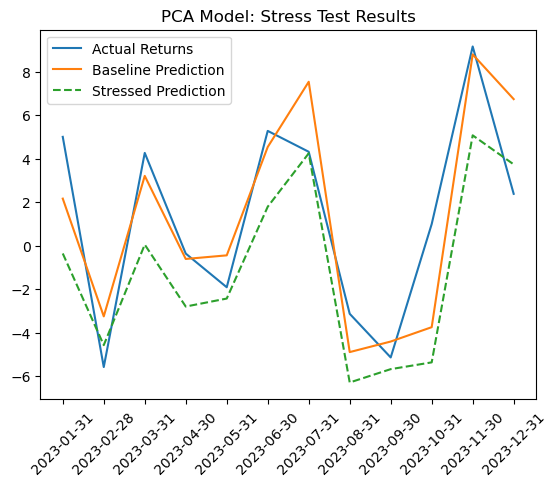


Mean Returns:
Mean Actual Returns: 1.2726
Mean Baseline Prediction: 1.3021
Mean Stressed Prediction: -1.0529


In [19]:
# ------------------------
# Using PCA Model
# ------------------------
# Predict using the stressed input
X_stressed_scaled = scaler.transform(X_stressed)
X_stressed_pca_df = pd.DataFrame(pca.transform(X_stressed_scaled)[:, :n_components], 
                             columns=pca_component_names, 
                             index=X_backtest.index)

if not significant_components.empty:
    X_stressed_pca_refined = sm.add_constant(X_stressed_pca_df[significant_components])
else:
    X_stressed_pca_refined = sm.add_constant(X_stressed_pca_df)  

y_stressed_pred_pca = pca_refined_model.predict(X_stressed_pca_refined)

# Plot results
plt.plot(y_backtest, label='Actual Returns')
plt.plot(y_backtest_pred_pca, label='Baseline Prediction')
plt.plot(y_stressed_pred_pca, label='Stressed Prediction', linestyle='--')
plt.legend()
plt.title('PCA Model: Stress Test Results')
plt.xticks(rotation=45)
plt.show()

result_df = pd.DataFrame({
    'Actual Returns': y_backtest,
    'Baseline Prediction': y_backtest_pred_reg,
    'Stressed Prediction': y_stressed_pred_pca
})

mean_actual = y_backtest.mean()
mean_baseline = y_backtest_pred_pca.mean()
mean_stressed = y_stressed_pred_pca.mean()

print(f"\nMean Returns:")
print(f"Mean Actual Returns: {mean_actual:.4f}")
print(f"Mean Baseline Prediction: {mean_baseline:.4f}")
print(f"Mean Stressed Prediction: {mean_stressed:.4f}")